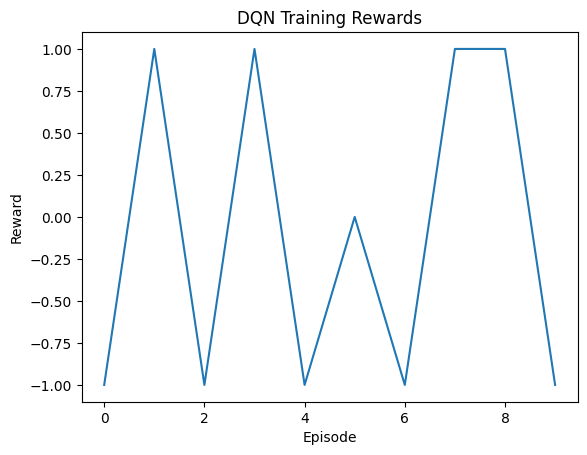

Dealer's Face-up Card: 7
Player's Hand: [2, 10] (Sum: 12)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step

Q-values: Hit=-0.14, Leave=-0.03
RNN Prediction (Win Probability): 0.52
Heuristic Recommendation: Leave
Monte Carlo Win Probability: 0.25
Ensemble Score: 0.15
Ensemble Recommendation: Leave
Do you want to follow the ensemble recommendation? (yes/no): yes
Action: Hit
Player's Hand: [2, 10, 10] (Sum: 22)
Dealer's Face-up Card: 7
Dealer's Hand Revealed: [7, 10] (Sum: 17)
You lose!


In [ ]:
import random
import numpy as np
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 6 * 4

def reset_deck():
    global deck  #
    deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 8 * 4

# Function to deal a card and remove it from the deck
def deal_card():
    if not deck:  # Check if the deck is empty
        reset_deck()  # Reinitialize the deck if it's empty
    card = random.choice(deck)
    deck.remove(card)
    return card

# Function to calculate the sum of a hand
def calculate_hand_sum(hand):
    total = sum(hand)
    # Handle ace (1) as 11 if it doesn't bust the hand
    if 1 in hand and total + 10 <= 21:
        total += 10
    return total

# Define DQN parameters
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # Neural network model with LSTM
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.LSTM(24, input_shape=(1, self.state_size)))
        model.add(tf.keras.layers.Dense(24, activation='relu'))
        model.add(tf.keras.layers.Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Random action (exploration)
        q_values = self.model.predict(state)  # Ensure state is shaped (1, 1, 2)
        return np.argmax(q_values[0])  # Best action (exploitation)

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Blackjack environment for training DQN
class BlackjackEnv:
    def __init__(self):
        self.reset()

    def reset(self):
        reset_deck()  # Ensure the deck is reset when starting a new game
        self.player_hand = [deal_card(), deal_card()]
        self.dealer_hand = [deal_card(), deal_card()]
        return self.get_state()

    def get_state(self):
        player_sum = calculate_hand_sum(self.player_hand)
        dealer_card = self.dealer_hand[0]
        # Reshape to include time steps dimension (1, 1, 2)
        return np.array([player_sum, dealer_card]).reshape(1, 1, 2)

    def step(self, action):
        if action == 0:  # Hit
            self.player_hand.append(deal_card())
            player_sum = calculate_hand_sum(self.player_hand)
            if player_sum > 21:  # Player busts
                return self.get_state(), -1, True  # Loss
            else:
                return self.get_state(), 0, False  # Continue
        else:  # Leave
            dealer_sum = calculate_hand_sum(self.dealer_hand)
            while dealer_sum < 17:
                self.dealer_hand.append(deal_card())
                dealer_sum = calculate_hand_sum(self.dealer_hand)
            player_sum = calculate_hand_sum(self.player_hand)
            if dealer_sum > 21 or player_sum > dealer_sum:  # Dealer busts or player wins
                return self.get_state(), 1, True  # Win
            elif player_sum < dealer_sum:
                return self.get_state(), -1, True  # Loss
            else:
                return self.get_state(), 0, True  # Draw

# Monte Carlo simulation for personalized strategy recommendation
def monte_carlo_simulation(player_sum, dealer_card, num_simulations=1000):
    wins = 0
    for _ in range(num_simulations):
        env = BlackjackEnv()
        env.player_hand = [player_sum, 0]  # Simulate with current player sum and a dummy card
        env.dealer_hand = [dealer_card, deal_card()]  # Dealer shows one card
        done = False
        while not done:
            if calculate_hand_sum(env.player_hand) < 21:  # If player can still hit
                action = random.choice([0, 1])  # Randomly choose to hit or leave
                _, reward, done = env.step(action)
            else:
                _, reward, done = env.step(1)  # Leave
        if reward == 1:  # Win
            wins += 1
    return wins / num_simulations  # Return the win probability

# Heuristic-based recommendation
def heuristic_recommendation(player_sum, dealer_card):
    if player_sum < 12:
        return 0  # Hit
    elif player_sum >= 17:
        return 1  # Leave
    else:
        return 0 if dealer_card < 7 else 1  # Hit if dealer shows 6 or lower, otherwise leave

# Define RNN parameters
class RNNModel:
    def __init__(self):
        self.model = self._build_model()

    def _build_model(self):
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.LSTM(24, input_shape=(1, 2)))
        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # Output win probability
        model.compile(loss='binary_crossentropy', optimizer='adam')
        return model

    def predict(self, state):
        return self.model.predict(state)

# Train the RNN model
def train_rnn_model(data, labels, epochs=100):
    rnn = RNNModel()
    rnn.model.fit(data, labels, epochs=epochs, verbose=0)
    return rnn

def train_dqn():
    env = BlackjackEnv()
    state_size = 2
    action_size = 2
    agent = DQNAgent(state_size, action_size)
    episodes = 10
    batch_size = 32
    rewards = []

    for e in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
        rewards.append(total_reward)
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

    # Plot the training results
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('DQN Training Rewards')
    plt.show()

    return agent

# Voting Classifier for ensemble
# class EnsembleClassifier(BaseEstimator, ClassifierMixin):
#     def __init__(self, models):
#         self.models = models

#     def fit(self, X, y):
#         for model in self.models:
#             model.fit(X, y)
#         return self

#     def predict(self, X):
#         predictions = np.zeros((X.shape[0], len(self.models)))
#         for i, model in enumerate(self.models):
#             predictions[:, i] = model.predict(X)
#         return np.round(np.mean(predictions, axis=1))

# Interactive Blackjack game using trained DQN and ensemble
# Interactive Blackjack game using trained DQN and ensemble
def blackjack_game(agent, rnn):
    env = BlackjackEnv()
    state = env.reset()

    # Initial state information
    print(f"Dealer's Face-up Card: {env.dealer_hand[0]}")  # Show dealer's first card
    print(f"Player's Hand: {env.player_hand} (Sum: {calculate_hand_sum(env.player_hand)})")  # Show player's cards and sum

    while True:
        # Get Q-values for hit and leave actions
        q_values = agent.model.predict(state)[0]
        hit_prob = q_values[0]
        leave_prob = q_values[1]

        # Monte Carlo recommendations
        player_sum = calculate_hand_sum(env.player_hand)
        dealer_card = env.dealer_hand[0]
        win_probability = monte_carlo_simulation(player_sum, dealer_card)

        # RNN prediction
        rnn_input = np.array([[player_sum, dealer_card]]).reshape(1, 1, 2)
        rnn_prediction = rnn.predict(rnn_input)[0][0]  # Get the predicted win probability

        # Heuristic recommendation
        heuristic_action = heuristic_recommendation(player_sum, dealer_card)

        # Combine recommendations (ensemble logic)
        ensemble_score = (hit_prob + leave_prob + win_probability + rnn_prediction) / 4

        # Display the values for Q-values, RNN, Heuristic, Monte Carlo, and Ensemble Score
        print(f"\nQ-values: Hit={hit_prob:.2f}, Leave={leave_prob:.2f}")
        print(f"RNN Prediction (Win Probability): {rnn_prediction:.2f}")
        print(f"Heuristic Recommendation: {'Hit' if heuristic_action == 0 else 'Leave'}")
        print(f"Monte Carlo Win Probability: {win_probability:.2f}")
        print(f"Ensemble Score: {ensemble_score:.2f}")

        # Present the ensemble recommendation
        if ensemble_score > 0.5:
            print("Ensemble Recommendation: Hit")
        else:
            print("Ensemble Recommendation: Leave")

        # User input for decision
        user_input = input("Do you want to follow the ensemble recommendation? (yes/no): ").strip().lower()

        if user_input == 'yes':
            action = 0 if ensemble_score > 0.5 else 1  # Hit if score > 0.5, otherwise leave
        else:
            # Ask the user for their action
            user_action = input("Enter your action (hit/leave): ").strip().lower()
            action = 0 if user_action == 'hit' else 1  # Hit is 0, Leave is 1

        print(f"Action: {'Hit' if action == 0 else 'Leave'}")

        # Perform the action
        next_state, reward, done = env.step(action)
        print(f"Player's Hand: {env.player_hand} (Sum: {calculate_hand_sum(env.player_hand)})")
        print(f"Dealer's Face-up Card: {dealer_card}")

        # Reveal the dealer's hand at the end of the round
        if done:
            dealer_sum = calculate_hand_sum(env.dealer_hand)
            print(f"Dealer's Hand Revealed: {env.dealer_hand} (Sum: {dealer_sum})")

            if reward == 1:
                print("You win!")
            elif reward == -1:
                print("You lose!")
            else:
                print("It's a draw!")
            break

# Train DQN agent and start the game
if __name__ == "__main__":
    trained_agent = train_dqn()

    # Generate training data for RNN (example data)
    data = np.array([[calculate_hand_sum([deal_card()]), deal_card()] for _ in range(1000)])
    labels = np.random.randint(0, 2, size=(1000, 1))  # Random labels for training (0 or 1)
    trained_rnn = train_rnn_model(data.reshape(-1, 1, 2), labels)

    blackjack_game(trained_agent, trained_rnn)



In [ ]:
import pandas as pd

# Function to simulate 100 games and generate a DataFrame of results
def simulate_games(trained_agent, trained_rnn, num_games=1000):
    game_results = []

    for game in range(num_games):
        env = BlackjackEnv()
        state = env.reset()

        player_hand = env.player_hand.copy()
        dealer_hand = env.dealer_hand.copy()

        player_sum = calculate_hand_sum(player_hand)
        dealer_card = dealer_hand[0]

        # Get Q-values from the DQN model
        q_values = trained_agent.model.predict(state)[0]
        hit_prob_dqn = q_values[0]
        leave_prob_dqn = q_values[1]

        # Get Monte Carlo simulation win probability
        win_probability_mc = monte_carlo_simulation(player_sum, dealer_card)

        # RNN prediction for win probability
        rnn_input = np.array([[player_sum, dealer_card]]).reshape(1, 1, 2)
        rnn_prediction = trained_rnn.predict(rnn_input)[0][0]

        # Heuristic-based recommendation
        heuristic_action = heuristic_recommendation(player_sum, dealer_card)

        # Ensemble model decision
        ensemble_score = (hit_prob_dqn + leave_prob_dqn + win_probability_mc + rnn_prediction) / 4
        ensemble_action = 0 if ensemble_score > 0.5 else 1  # Hit if ensemble score > 0.5, else leave

        done = False
        while not done:
            action = ensemble_action  # Use the ensemble action to decide whether to hit or leave
            next_state, reward, done = env.step(action)

            if not done:
                state = next_state  # Continue to the next state

        # Store game results
        game_results.append({
            'Player Cards': player_hand,
            'Dealer Cards': dealer_hand,
            'Player Win/Loss': 'Win' if reward == 1 else 'Loss' if reward == -1 else 'Draw',
            'Heuristic Prediction': 'Hit' if heuristic_action == 0 else 'Leave',
            'RNN Prediction (Win Probability)': rnn_prediction,
            'Monte Carlo Win Probability': win_probability_mc,
            'DQN Prediction': 'Hit' if hit_prob_dqn > leave_prob_dqn else 'Leave',
            'Ensemble Prediction': 'Hit' if ensemble_action == 0 else 'Leave'
        })

    # Convert the list of game results into a DataFrame
    df_results = pd.DataFrame(game_results)

    return df_results

# Print accuracy for each method
def calculate_accuracy(df):
    total_games = len(df)
    win_games = df[df['Player Win/Loss'] == 'Win']

    # Accuracy for Heuristic
    heuristic_correct = win_games[win_games['Heuristic Prediction'] == 'Leave']  # Heuristic assumes Leave is a winning strategy
    heuristic_accuracy = len(heuristic_correct) / total_games * 100

    # Accuracy for RNN
    rnn_correct = win_games[win_games['RNN Prediction (Win Probability)'] > 0.5]  # RNN assumes a win if prob > 0.5
    rnn_accuracy = len(rnn_correct) / total_games * 100

    # Accuracy for DQN
    dqn_correct = win_games[win_games['DQN Prediction'] == 'Leave']  # DQN assumes Leave is a winning strategy
    dqn_accuracy = len(dqn_correct) / total_games * 100

    # Accuracy for Ensemble
    ensemble_correct = win_games[win_games['Ensemble Prediction'] == 'Leave']  # Ensemble assumes Leave is a winning strategy
    ensemble_accuracy = len(ensemble_correct) / total_games * 100

    print(f"Heuristic Accuracy: {heuristic_accuracy:.2f}%")
    print(f"RNN Accuracy: {rnn_accuracy:.2f}%")
    print(f"DQN Accuracy: {dqn_accuracy:.2f}%")
    print(f"Ensemble Accuracy: {ensemble_accuracy:.2f}%")

if __name__ == "__main__":
    # Assuming `trained_agent` and `trained_rnn` are already trained models
    df_results = simulate_games(trained_agent, trained_rnn, num_games=100)

    # Display the DataFrame of results
    print(df_results)

    # Calculate and print the accuracy for each method
    calculate_accuracy(df_results)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

In [ ]:
df_results.to_csv('blackjack_simulation_results.csv', index=False)
